In [138]:
# Data fetching library
import requests as req
# used below: response = res

# Data manipulation libraries
import pandas as pd
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

# Data vizualization library (Vega-Lite)
from altair import *

# Quick Overview

In [137]:
# Pick a dataset name, table_name, and rw_id
dataset = 'Percentage of Urban Population with Access to Electricity'
table_name = 'soc_042_percentage_urban_population_access_electricity'
rw_id = '2e8b2cc0-bac3-4d01-b714-8943ff99347d'

# Use a pandas dataframe to store data you want to query with
# Later, we'll show how to upload a CSV to a DataFrame, 
# and then export the results back to a CSV with the additional data
locations = pd.DataFrame({"latitude":[0.3515602939922709, -3.951941],
                          "longitude": [23.5546875, -64.072266]}, 
                          index = ["Congo", "Brazil"])

# Construct a query and send it to RW API
## Build SQL for query
congo = locations.loc["Congo"]
brazil = locations.loc["Brazil"]
congo_geom = "ST_GeomFromText('POINT({} {})', 4326)".format(congo.longitude, congo.latitude)
brazil_geom = "ST_GeomFromText('POINT({} {})', 4326)".format(brazil.longitude, brazil.latitude)

sql = "".join(["SELECT * FROM {} WHERE ",
"ST_Intersects({}, ",
"{}.the_geom)"])

query_sql_congo = sql.format(table_name, congo_geom, table_name)
query_sql_brazil = sql.format(table_name, brazil_geom, table_name)

## Construct Query
# This query_base is the key to accessing data from RW
# It requires a dataset's rw_id and an SQL query
query_base = "https://api.resourcewatch.org/v1/query/{}?sql={}"
query_congo = query_base.format(rw_id, query_sql_congo)
query_brazil = query_base.format(rw_id, query_sql_brazil)

## Get results
res_congo = req.get(query_congo)
res_brazil = req.get(query_brazil)

congo_data =  res_congo.json()["data"][0]["yr_2014"]
brazil_data = res_brazil.json()["data"][0]["yr_2014"]

locations.loc["Congo", "Urban Electricity Access"] = congo_data
locations.loc["Brazil", "Urban Electricity Access"] = brazil_data

locations

,latitude,longitude,Urban Electricity Access
Congo,0.351560,23.554688,42.000000
Brazil,-3.951941,-64.072266,99.945554


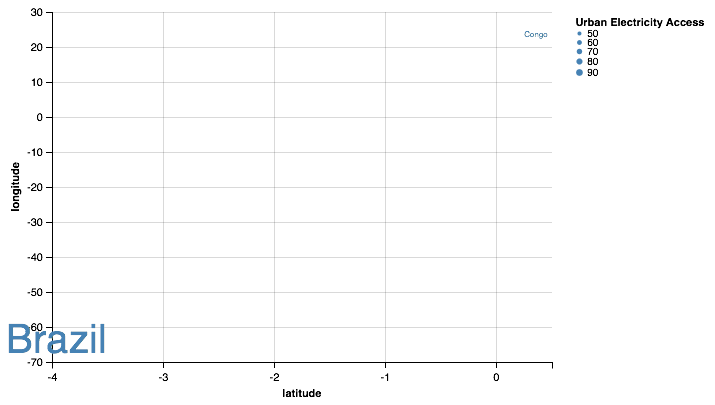

In [135]:
## Visualize the results using Altair (Vega-Lite chart maker)
# Vega-Lite has benefit of being easy to embed in websites

# Need to use "reset_index()" here because Altair only sees
# Data in Pandas DataFrame columns... it cannot read the index
Chart(locations.reset_index()).mark_text().encode(
    x="latitude",
    y="longitude",
    text='index',
    size="Urban Electricity Access"
)

# Find information about all data on the Resource Watch API, format as DataFrame

In [157]:
# Base URL for getting dataset metadata from RW API
# Metadata = Data that describes Data 
url = "https://api.resourcewatch.org/v1/dataset?sort=slug,-provider,userId&status=saved&includes=metadata,vocabulary,widget,layer"

# page[size] tells the API the maximum number of results to send back
# There are currently between 200 and 300 datasets on the RW API
payload = { "application":"rw", "page[size]": 1000}

# Request all datasets, and extract the data from the response
res = req.get(url, params=payload)
data = res.json()["data"]

#############################################################

### Convert the json object returned by the API into a pandas DataFrame
# Another option: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.io.json.json_normalize.html
datasets_on_api = {}
for ix, dset in enumerate(data):
    atts = dset["attributes"]
    metadata = atts["metadata"]
    layers = atts["layer"]
    widgets = atts["widget"]
    tags = atts["vocabulary"]
    datasets_on_api[atts["name"]] = {
        "rw_id":dset["id"],
        "table_name":atts["tableName"],
        "provider":atts["provider"],
        "date_updated":atts["updatedAt"],
        "num_metadata":len(metadata),
        "metadata": metadata,
        "num_layers":len(layers),
        "layers": layers,
        "num_widgets":len(widgets),
        "widgets": widgets,
        "num_tags":len(tags),
        "tags":tags
    }

# Create the DataFrame, name the index, and sort by date_updated
# More recently updated datasets at the top
current_datasets_on_api = pd.DataFrame.from_dict(datasets_on_api, orient='index')
current_datasets_on_api.index.rename("Dataset", inplace=True)
current_datasets_on_api.sort_values(by=["date_updated"], inplace=True, ascending = False)

In [158]:
# View all datasets on the Resource Watch API
current_datasets_on_api

,rw_id,table_name,provider,date_updated,num_metadata,metadata,num_layers,layers,num_widgets,widgets,num_tags,tags
Dataset,,,,,,,,,,,,
Irrigated Crop Water Requirement and Withdrawal,b4dbb3a5-654f-4f36-aa32-c28f7406d6f4,foo_008_irrigated_crop_requirement_withdrawal_...,cartodb,2017-09-13T14:47:51.432Z,0,[],0,[],0,[],0,[]
Internationally Important Wetlands,c02da519-12f3-4c6a-86e7-648afac80b23,for_014_internationally_important_wetlands,cartodb,2017-09-13T14:02:58.198Z,0,[],1,[{'id': '473fc70a-81cd-47c4-8cc4-938a57ffa3d2'...,0,[],1,"[{'type': 'vocabulary', 'attributes': {'resour..."
Gender Development Index,d4ca3cc4-c162-469c-b341-b52284a73eaa,soc_002_gender_development_index,cartodb,2017-09-13T13:41:39.975Z,0,[],1,[{'id': '3ff24d05-7a38-49d3-a14a-cec86a29578d'...,0,[],0,[]
Maritime Boundaries,bf5877eb-399a-4237-b510-b1d41049e3bc,com_011_1_maritime_boundaries_territorial_waters,cartodb,2017-09-13T13:07:26.295Z,0,[],3,[{'id': 'f30d172f-ccf5-460e-9bcf-0fe4ce4d470a'...,0,[],0,[]
test 1,10faee1b-c08f-4496-8469-e16c5b9058aa,index_10faee1bc08f44968469e16c5b9058aa,csv,2017-09-13T10:18:51.733Z,0,[],0,[],0,[],0,[]
Global grey water footprint and Water Pollution Levels related to anthropogenic Nitrogen loads to fresh water.,bbadb233-84ea-4ae1-893f-deba67f1d5de,global_grey_water_footprint_and_water_pollutio...,cartodb,2017-09-13T09:52:31.369Z,0,[],1,[{'id': 'b43325a0-b9f1-4eda-b457-f1cadf9fadd2'...,0,[],1,"[{'type': 'vocabulary', 'attributes': {'resour..."
Gross Domestic Product,52c55378-0484-48c3-92fc-3ee94d21c716,com_010_gdp_ppp_usd,cartodb,2017-09-12T20:43:04.313Z,0,[],1,[{'id': 'f98f8874-3d5d-4818-a75c-29a8d1b57cb3'...,0,[],0,[]
Reduction in Life Expectancy Attributable to the Environment,5d269c36-6ccf-4620-838d-431f86c30f69,cit_013_reduction_life_expect_environment,cartodb,2017-09-12T19:27:28.399Z,0,[],1,[{'id': 'b0a8f63f-e3a3-4599-abd8-19120edd98b1'...,0,[],1,"[{'type': 'vocabulary', 'attributes': {'resour..."
Land Deals,e7780d53-ad80-45bd-a271-79615ee97a37,soc_035_land_deals,cartodb,2017-09-12T18:00:35.481Z,0,[],0,[],0,[],1,"[{'type': 'vocabulary', 'attributes': {'resour..."


In [160]:
# Choose only datasets stored on:
# cartodb, gee, featureservice, wms, rasdaman
# provider = None to receive ALL datasets
provider = "cartodb"
carto_ids = (current_datasets_on_api["provider"]==provider)
carto_data = current_datasets_on_api.loc[carto_ids]

print("Number of Carto datasets: ", data_on_rw.shape[0])

Number of Carto datasets:  168


In [164]:
# Not all datasets have a valid geometry
# Make a list to give to Liz
carto_head = carto_data.head(15)

query_base = "https://api.resourcewatch.org/v1/query/{}?sql={}"
sql = "SELECT * FROM {} LIMIT 1"

def find_none_geoms(row):
    sql_f = sql.format(row.table_name)
    print(sql_f)
    res = req.get(query_base.format(row.rw_id, sql_f))
    #print(res.text)
    data = res.json()["data"][0]
    return(data)

a = carto_head.apply(find_none_geoms, axis=1)

SELECT * FROM foo_008_irrigated_crop_requirement_withdrawal_edit LIMIT 1
SELECT * FROM for_014_internationally_important_wetlands LIMIT 1
SELECT * FROM soc_002_gender_development_index LIMIT 1
SELECT * FROM com_011_1_maritime_boundaries_territorial_waters LIMIT 1
SELECT * FROM global_grey_water_footprint_and_water_pollution_levels LIMIT 1
SELECT * FROM com_010_gdp_ppp_usd LIMIT 1
SELECT * FROM cit_013_reduction_life_expect_environment LIMIT 1
SELECT * FROM soc_035_land_deals LIMIT 1
SELECT * FROM wb_life_expectancy_birth LIMIT 1
SELECT * FROM wb_individuals_using_internet LIMIT 1
SELECT * FROM wb_employment_ratio LIMIT 1
SELECT * FROM wb_gdp_2010_constant LIMIT 1
SELECT * FROM wb_access_to_electricity LIMIT 1
SELECT * FROM sp_richness LIMIT 1
SELECT * FROM aqueduct_global_flood_risk_data_by_country_20150304 LIMIT 1


In [168]:
geoms = [b["the_geom"] for b in a if "the_raster_webmercator" not in b.keys()]
which


[None,
 '0106000020E610000001000000010300000001000000CF0C0000C0036BE6DA591840F043234716194740006FDD6FE259184090F095641019474000EE9D2C105A1840504F6C330519474040A846CE135A1840C007AA11FD1847408074445B215A1840A0E2096EF818474000E8E15F5F5A184078DFECD4F118474000C1753C9B5A1840783E23AEEF18474000F083DFC55A184068A78B26ED18474000EC25ACDE5A1840D8DD8260E6184740808544E9F15A1840880C22F4E1184740805C19FE1A5B1840706C584EE01847404004B459675B1840481D6298E0184740C04269DA8B5B18405812ED58DC18474080E1E6B2A35B1840384A7C60DA184740409753D7E15B1840C099D447D518474040FB5396605C184078DB4BA8CD18474080C162F3C25C184058C5D178C9184740C0E942ACFE5C184010FDDA67C618474040428BDC3B5D184070555D1DC6184740C041785E715D184010DF1E2BC818474080537D00B55D1840C0918BC7CB18474000AEA0DBDE5D1840E8C641CACE184740C04E136C125E1840D887D6A6CB184740009FBDA7305E1840A8C0CE5CC61847400089E1BD7F5E184090905170C118474000934107C05E1840E87A2B4ABD184740C05F59180B5F1840B0EA5683BB18474040FE5E6D395F184008E83CD2BC18474040305993A95F18401822D80CBE184740004614FD1B6

# Import CSV with lat, lon points. These can be used to get information out of the Resource Watch API

In [73]:
DATA_FOLDER = ROOT_FOLDER + "data/"

# src: https://developers.google.com/public-data/docs/canonical/countries_csv
country_capitols = pd.read_csv(DATA_FOLDER + "country_capitols.tsv", sep="\t")

country_capitols.head()

,country,latitude,longitude,name
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla


# Create queries to retrieve specific information from the Resource Watch API

In [9]:
# Template query string used to query RW datasets
query_base = "https://api.resourcewatch.org/v1/query/{}?sql={}"
query_payload = { "application":"rw", "page[size]": 1000}

# Template SQL string used in RW query
sql = "".join(["SELECT * FROM {} WHERE ",
"ST_Intersects({}, ",
"{}.the_geom)"])

In [78]:
%%timeit

# Pick a dataset rw_id from data_on_rw
dataset = 'Percentage of Urban Population with Access to Electricity'

# Select the Carto table name, and Resource Watch ID (rw_id)
# The rw_id is needed to query the RW API
table_name = carto_data.loc[dataset, "table_name"]
rw_id = carto_data.loc[dataset, "id"]

def query_api(row):
    # Construct a Well-Known-Text (WKT) Point string
    # WKT formats points: 'POINT(Latitude Longitude)'
    # https://www.drupal.org/node/511370
    point = "ST_GeomFromText('POINT({} {})', 4326)".format(row.latitude, row.longitude)
    
    # Use the templates defined above to create/send a query to RW API
    query_sql = sql.format(table_name, point, table_name)
    query = query_base.format(rw_id, query_sql)    
    res = req.get(query, params=query_payload)

    # Try, except: useful in python to catch errors,
    # and provide an alternative action if an error occurs
    try:
        data = res.json()["data"]
        return(data[0]["yr_2014"])
    except:
        return("No matching data found")


country_capitols["ElectricityAccess"] = pd.Series(query_api(row) for row in country_capitols.itertuples())

From cffi callback <function _verify_callback at 0x115ec2d90>:
Traceback (most recent call last):
  File "/Users/nathansuberi/.pyenv/versions/3.6.0/lib/python3.6/site-packages/OpenSSL/SSL.py", line 221, in wrapper
    @wraps(callback)
KeyboardInterrupt


SSLError: HTTPSConnectionPool(host='api.resourcewatch.org', port=443): Max retries exceeded with url: /v1/query/2e8b2cc0-bac3-4d01-b714-8943ff99347d?sql=SELECT%20*%20FROM%20soc_042_percentage_urban_population_access_electricity%20WHERE%20ST_Intersects(ST_GeomFromText('POINT(42.602636%2020.902977)',%204326),%20soc_042_percentage_urban_population_access_electricity.the_geom)&application=rw&page%5Bsize%5D=100000000000 (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')],)",),))

In [74]:
country_capitols

,country,latitude,longitude,name
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla
5,AL,41.153332,20.168331,Albania
6,AM,40.069099,45.038189,Armenia
7,AN,12.226079,-69.060087,Netherlands Antilles
8,AO,-11.202692,17.873887,Angola
9,AQ,-75.250973,-0.071389,Antarctica


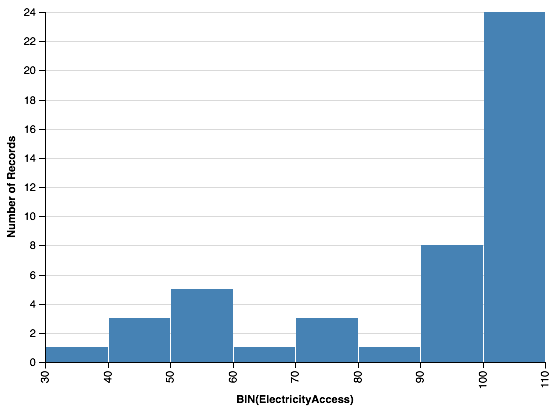

In [31]:
# Add a plot to show something about it

Chart(country_capitols).mark_bar().encode(
x=X("ElectricityAccess", bin=Bin()),
y="count(*)")

In [48]:
#geojson1 = geocache["geojson"][geojson_file]
query2 = geocache["csv"][csv_file]["query"]

#rw_id = "223b936e-06b8-4970-abd9-4f123904d95d"
table_name = carto_datasets.loc[rw_id, "table_name"]
print(table_name)

## TO DO: Add support for creating a buffer

sql = "".join(["SELECT * FROM {} WHERE ",
"ST_Intersects({}, ",
"{}.the_geom)"])

#sql1 = sql.format(json.dumps(geojson1), table_name, table_name)
sql2 = sql.format(table_name, query2, table_name)
#sql2 = sql.format(table_name)



query_base = "https://api.resourcewatch.org/v1/query/{}?sql={}"

#query1 = query_base.format(rw_id,sql1)
query2 = query_base.format(rw_id,sql2)

payload = { "application":"rw", "page[size]": 100000000000}

#res1 = req.get(query1, params=payload)
res2 = req.get(query2, params=payload)

#data1 = res1.json()["data"]
data2 = res2.json()["data"]

soc_042_percentage_urban_population_access_electricity


In [53]:
[ctry["country_name"] for ctry in data2]

['Argentina', 'Brazil', 'Greenland', 'Russian Federation']

# Experimentation below

In [11]:
# list1 = [1,2,3]
# list2 = [4,5,6]
# lists = pd.DataFrame({"l1":list1, "l2":list2})
# print(lists)
# def add(a,b):
#     return(a+b)

# list(map(add, lists["l1"], lists["l2"]))

In [5]:
# View current data files (csv and geojson) available as AOI
# Call geostore, as these are cached geometries available to query with
csv_src = glob(DATA_FOLDER+"*.csv")
geojson_src = glob(DATA_FOLDER+"*.json")

geocache = {
    "csv":{},
    "geojson":{}
}

for src in csv_src:
    geocache["csv"][src] = []
for src in geojson_src:
    geocache["geojson"][src] = []

geocache

## TO ACCESS
# geostore["csv"][src] = pd.read_csv(geostore["csv"][0]) 
# with open(geostore["geojson"][0], 'r') as src_data:
#     geostore["geojson"][0] = json.load(src_data)

{'csv': {'/Users/nathansuberi/Desktop/WRI_Programming/Py_Scripts/API Use Examples/data/csv_test1.csv': []},
 'geojson': {'/Users/nathansuberi/Desktop/WRI_Programming/Py_Scripts/API Use Examples/data/geojson_test1.json': []}}

In [1]:
# Grab dataset metadata for all providers
all_datasets = rw.get_rw_datasets()
# Grab dataset metadata for Carto stored datasets
carto_datasets = rw.get_rw_datasets(provider="cartodb")
# Grab dataset metadata for Google Earth Engine stored datasets
gee_datasets = rw.get_rw_datasets(provider="gee")
# Grab dataset metadata for featureservice stored datasets
feature_service_datasets = rw.get_rw_datasets(provider="featureservice")

NameError: name 'rw' is not defined

In [ ]:
# Define bounding box area of interest (AOI) in lat/lons
MAX_LAT = 90
MIN_LAT = -90

MAX_LON = 180
MIN_LON = -180

# Create a random CSV of lat longs in the AOI
num_records = 20
random_lons = np.random.random(num_records) * (MAX_LON - MIN_LON) + MIN_LON
random_lats = np.random.random(num_records) * (MAX_LAT - MIN_LAT) + MIN_LAT

pd.DataFrame({"longitude":random_lons, 
              "latitude":random_lats}).to_csv(DATA_FOLDER+"csv_test1.csv")

In [6]:
csv_file = csv_src[0]
geocache["csv"][csv_file] = {
    "orig_data":pd.read_csv(csv_file, index_col=[0]),
}
geocache["csv"][csv_file]["geojson"] = rw.create_geojson_from_csv(geocache["csv"][csv_file]["orig_data"])
geocache["csv"][csv_file]["wkt_geojson"] = rw.create_wkt_geom_lists(geocache["csv"][csv_file]["geojson"]["features"])
geocache["csv"][csv_file]["query"] = rw.create_wkt_union_statement(geocache["csv"][csv_file]["wkt_geojson"]["points"])


In [13]:
geojson_file = geojson_src[0]
geocache["geojson"][geojson_file] = json.load(open(geojson_file,'r'))
geocache